# Practice Session 03: Networks from text

*Introduction to Network Science* (2025/26), UPF

Author: <font color="blue">Javier Algarra Perez</font>

E-mail: <font color="blue">javier.algarra01@estudiant.upf.edu</font>

Date: <font color="blue">16/10/2025</font>

# 1. Create the directed mention network

In [80]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [81]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [83]:
import io
import json
import gzip
import csv
import re
import pandas as pd

In [84]:
# Input file
COMPRESSED_INPUT_FILENAME = "data/CovidLockdownCatalonia.json.gz"   # You may need to change this filepath depending on where you've saved the data file

# These are the output files, leave as-is
OUTPUT_ALL_EDGES_FILENAME = "CovidLockdownCatalonia.csv"
OUTPUT_FILTERED_EDGES_FILENAME = "CovidLockdownCatalonia-min-weight-filtered.csv"
OUTPUT_CO_MENTIONS_FILENAME = "CovidLockdownCatalonia-co-mentions.csv"

## 1.1. Extract mentions

In [85]:
# Leave this code as-is

def extract_mentions(text):
    return re.findall("@([a-zA-Z0-9_]{5,20})", text)

print(extract_mentions("RT @elnacionalcat: check this post by @en_blau"))



['elnacionalcat', 'en_blau']


## 1.2. Count mentions


In [86]:
mentions_counter = {}

with gzip.open(COMPRESSED_INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    for line in input_file:
        tweet = json.loads(line)
        author = tweet['user']['screen_name']
        message = tweet['full_text']

        mentions = extract_mentions(message)
        for mentioned_user in mentions:
            mentions_counter.setdefault((author, mentioned_user), 0)
            mentions_counter[(author, mentioned_user)] += 1



In [87]:
print(mentions_counter[('joanmariapique', 'catalangov')])


9


In [88]:
print(mentions_counter)
for pair, count in list(mentions_counter.items())[:10]:
    print(pair[0])

{('Old_Nemo', 'aramateix'): 1, ('Old_Nemo', 'govern'): 1, ('rhinomni', 'RBReich'): 1, ('ForquillaBDN', 'Totbadalona'): 1, ('ZainulAriffn', 'rafiziramli'): 1, ('sarizor', 'gominolasdpetro'): 1, ('lunavegan', 'borisbarrera'): 1, ('XaviMarti5', 'XSalaimartin'): 2, ('Gotirb', 'nichcarlson'): 1, ('suruasinoiD', 'marctarinmarti'): 1, ('GuifrePpcc', 'MACanadell'): 1, ('Lajurita', 'boticariagarcia'): 1, ('marta_ter', 'EmilioMorenatti'): 1, ('AndreuCriquet', 'decaminoapekin'): 1, ('LLUISNARO', 'angeliufus'): 1, ('SpanishDan1', 'Pumpkinz16'): 1, ('tutmosh', 'brasil247'): 1, ('JavierBcn72', 'FincaSantaMarga'): 1, ('annetakawaii', 'XSalaimartin'): 1, ('emicaza', 'SaludPublicaEs'): 1, ('PregonerSantEst', 'polispol'): 1, ('irisgonzalezaf', 'ChicoMeteoro'): 1, ('maarinaacastroo', 'Rodrigotb__'): 1, ('jdc_jesu', 'Sayo_cab75'): 1, ('jlvndr', 'GillianHTurner'): 1, ('annamfabra', 'javihdez'): 1, ('Carrerasxavi', 'HectorPumo'): 1, ('JorginaMarser', 'IldeVrMy'): 1, ('JorginaMarser', 'pr_soc'): 1, ('mirovir

In [89]:
accounts_with_more_than_8_mentions = set()

for key in mentions_counter:
    key2 = ()
    user = key[0]
    mention = key[1]
    total = mentions_counter[key]
    key2 = tuple((mention, user))
    if key2 in mentions_counter:
        suma2 = mentions_counter[key2]
        total += suma2

    if total > 8 and user != mention:
        accounts_with_more_than_8_mentions.add((user, mention, total))



for u, v, total in accounts_with_more_than_8_mentions:
    print(f"Accounts @{u} and @{v} mention each other {total} times")           
    

Accounts @Txesnut1 and @DrEricDing mention each other 11 times
Accounts @joanmariapique and @catalangov mention each other 9 times
Accounts @wualaswold1 and @updayESP mention each other 9 times
Accounts @FXstreetNews and @HareshMenghani mention each other 11 times
Accounts @emocionycambio and @DrTedros mention each other 16 times


## 1.3 Save network

In [90]:
# Leave this code as-is

lines_written = 0

with io.open(OUTPUT_ALL_EDGES_FILENAME, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"')
    writer.writerow(["Source", "Target", "Weight"])
    for key in mentions_counter:
        author = key[0]
        mention = key[1]
        weight = mentions_counter[key]
        writer.writerow([author, mention, weight])
        lines_written += 1

print(f"Wrote {lines_written} lines to file {OUTPUT_ALL_EDGES_FILENAME}")

Wrote 34040 lines to file CovidLockdownCatalonia.csv


In [91]:
# Leer el archivo CSV
min_weight = 3
filtered_lines_written = 0

with io.open(OUTPUT_FILTERED_EDGES_FILENAME, "w") as output_file_filtered:
    filtered_writer = csv.writer(output_file_filtered, delimiter='\t', quotechar='"')
    filtered_writer.writerow(["Source", "Target", "Weight"])
    for key in mentions_counter:
        author = key[0]
        mention = key[1]
        weight = mentions_counter[key]
        if weight >= min_weight:
            filtered_writer.writerow([author, mention, weight])
            filtered_lines_written += 1

print(f"Wrote {filtered_lines_written} lines to file {OUTPUT_FILTERED_EDGES_FILENAME} with min weight {min_weight}")



Wrote 255 lines to file CovidLockdownCatalonia-min-weight-filtered.csv with min weight 3


# 2. Visualize the directed mention network


In [92]:
# Import required packages

import networkx as nx
import matplotlib.pyplot as plt

In [93]:
# Crear un grafo dirigido
g = nx.DiGraph()

with open(OUTPUT_FILTERED_EDGES_FILENAME, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")  
    for row in reader:
        source = row["Source"]
        target = row["Target"]
        weight = int(row["Weight"])
        g.add_edge(source, target, weight=weight)

print(f"Número de nodos: {g.number_of_nodes()}")
print(f"Número de aristas: {g.number_of_edges()}")



Número de nodos: 357
Número de aristas: 255


In [94]:
# Leave this code as-is
list(nx.get_edge_attributes(g, 'weight').items())[:10]

[(('AlfonsGorina', 'movieweb'), 5),
 (('McIslamofobia', 'carlesplb'), 3),
 (('marsicilia', 'javiernegre10'), 4),
 (('wualaswold1', 'updayESP'), 9),
 (('RedPillDetox', 'TomthunkitsMind'), 7),
 (('SpanishDan1', 'fascinatorfun'), 8),
 (('SpanishDan1', 'g_gosden'), 6),
 (('SpanishDan1', 'BorisJohnson'), 4),
 (('SpanishDan1', 'miffythegamer'), 6),
 (('SpanishDan1', 'Haggis_UK'), 4)]

## 2.1. Extract the largest connected component using NetworkX

In [95]:
# Leave this code as-is

print(f"The network is weakly connected: {nx.is_weakly_connected(g)}")
print(f"The network is strongly connected: {nx.is_strongly_connected(g)}")

The network is weakly connected: False
The network is strongly connected: False


In [96]:
largest_cc_nodes = max(nx.weakly_connected_components(g), key=len)

# Crear el subgrafo correspondiente
lcc = g.subgraph(largest_cc_nodes).copy()

print(f"Número de nodos en el LCC: {lcc.number_of_nodes()}")
print(f"Número de aristas en el LCC: {lcc.number_of_edges()}")


Número de nodos en el LCC: 90
Número de aristas en el LCC: 95


In [97]:
# Leave this code as-is

print(f"The network is weakly connected: {nx.is_weakly_connected(lcc)}")
print(f"The network is strongly connected: {nx.is_strongly_connected(lcc)}")

The network is weakly connected: True
The network is strongly connected: False


## 2.2. Visualize the largest connected component


In [98]:
G_undirected = lcc.to_undirected()
edge_betweenness = nx.edge_betweenness_centrality(G_undirected, weight='weight')


In [99]:
for (u, v), b in edge_betweenness.items():
    if lcc.has_edge(u, v):
        lcc.edges[u, v]['betweenness'] = b
    elif lcc.has_edge(v, u): 
        lcc.edges[v, u]['betweenness'] = b


In [100]:
betweenness = nx.edge_betweenness_centrality(G_undirected)

nx.set_edge_attributes(lcc, betweenness, 'betweenness')

# Check the edges to confirm the 'betweenness' attribute has been added
for u, v, data in lcc.edges(data=True):
    print(f"Edge ({u}, {v}) has betweenness: {data.get('betweenness')}")

Edge (jmpelleja, QuimTorraiPla) has betweenness: 0.022222222222222223
Edge (guelfa10, elnacionalcat) has betweenness: 0.022222222222222223
Edge (MargaXrepublica, govern) has betweenness: 0.11763628797336657
Edge (MargaXrepublica, saralidiaester) has betweenness: 0.022222222222222223
Edge (MargaXrepublica, MargaXrepublica) has betweenness: 0.0
Edge (MargaXrepublica, elnacionalcat) has betweenness: 0.10373699542238864
Edge (reus_cat, govern) has betweenness: 0.022222222222222223
Edge (46ccp, elnacionalcat) has betweenness: 0.022222222222222223
Edge (portet_bruguera, QuimTorraiPla) has betweenness: 0.043945068664169785
Edge (portet_bruguera, JuntsperMataro) has betweenness: 0.022222222222222223
Edge (eduguardia, QuimTorraiPla) has betweenness: 0.022222222222222223
Edge (JordiPuiggros1, elnacionalcat) has betweenness: 0.022222222222222223
Edge (PcLaGarriga, emergenciescat) has betweenness: 0.022222222222222223
Edge (Manu_K_tala, VilaWeb) has betweenness: 0.05472326258843113
Edge (Manu_K_ta

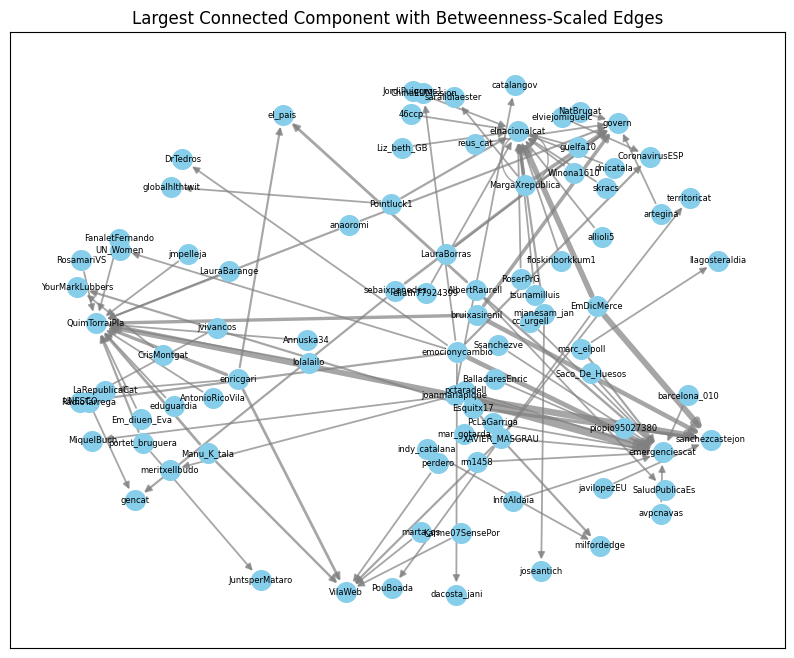

In [101]:
# Prepare the data for plotting
edge_betweenness_list = [lcc[u][v]['betweenness'] for u, v in lcc.edges()]
max_betweenness = max(edge_betweenness_list) 
edge_widths = [val / max_betweenness * 5 + 1 for val in edge_betweenness_list]

# Generate layout
pos = nx.spring_layout(lcc, weight='betweenness', seed=42)

# Create the plot
plt.figure(figsize=(10, 8))

# Draw the nodes
nx.draw_networkx_nodes(lcc, pos, node_color='skyblue', node_size=200)

# Draw the edges with scaled width
nx.draw_networkx_edges(lcc, pos, width=edge_widths, edge_color='gray', alpha=0.7)

# Draw the labels for nodes
nx.draw_networkx_labels(lcc, pos, font_size=6, font_family='sans-serif')

plt.title("Largest Connected Component with Betweenness-Scaled Edges")
plt.show()

In [102]:
# Leave this code as-is

top_edges = sorted(lcc.edges(data=True), key=lambda x: x[2]['betweenness'], reverse=True)[:10]
for edge in top_edges:
    print(f"Edge from @{edge[0]} to @{edge[1]} has betweenness {edge[2]['betweenness']:.3f}")

Edge from @joanmariapique to @emergenciescat has betweenness 0.375
Edge from @joanmariapique to @sanchezcastejon has betweenness 0.278
Edge from @EmDicMerce to @sanchezcastejon has betweenness 0.244
Edge from @joanmariapique to @QuimTorraiPla has betweenness 0.234
Edge from @EmDicMerce to @elnacionalcat has betweenness 0.223
Edge from @emocionycambio to @emergenciescat has betweenness 0.182
Edge from @bruixasirenil to @sanchezcastejon has betweenness 0.169
Edge from @bruixasirenil to @govern has betweenness 0.118
Edge from @MargaXrepublica to @govern has betweenness 0.118
Edge from @bruixasirenil to @QuimTorraiPla has betweenness 0.107


In [103]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [104]:
# Leave this code as-is (for now)

pos = nx.spring_layout(     # The function returns a dictionary with node positions (2D coordinates)...
    lcc,                    # ...for nodes in the largest connected component...
    weight='betweenness',   # ...using edge betweenness as an attractive force...
    method='energy',        # ...using the energy minimization method (see documentation for details)...
    k=0.1,                  # ...with a custom setting for the optimal distance between nodes.
    seed=42          # We also set the RNG seed to make the layout reproducible.
)

Diameter of the largest connected component: 10
Largest connected component size: 90 nodes (25.21% of total)
Second largest connected component size: 17 nodes


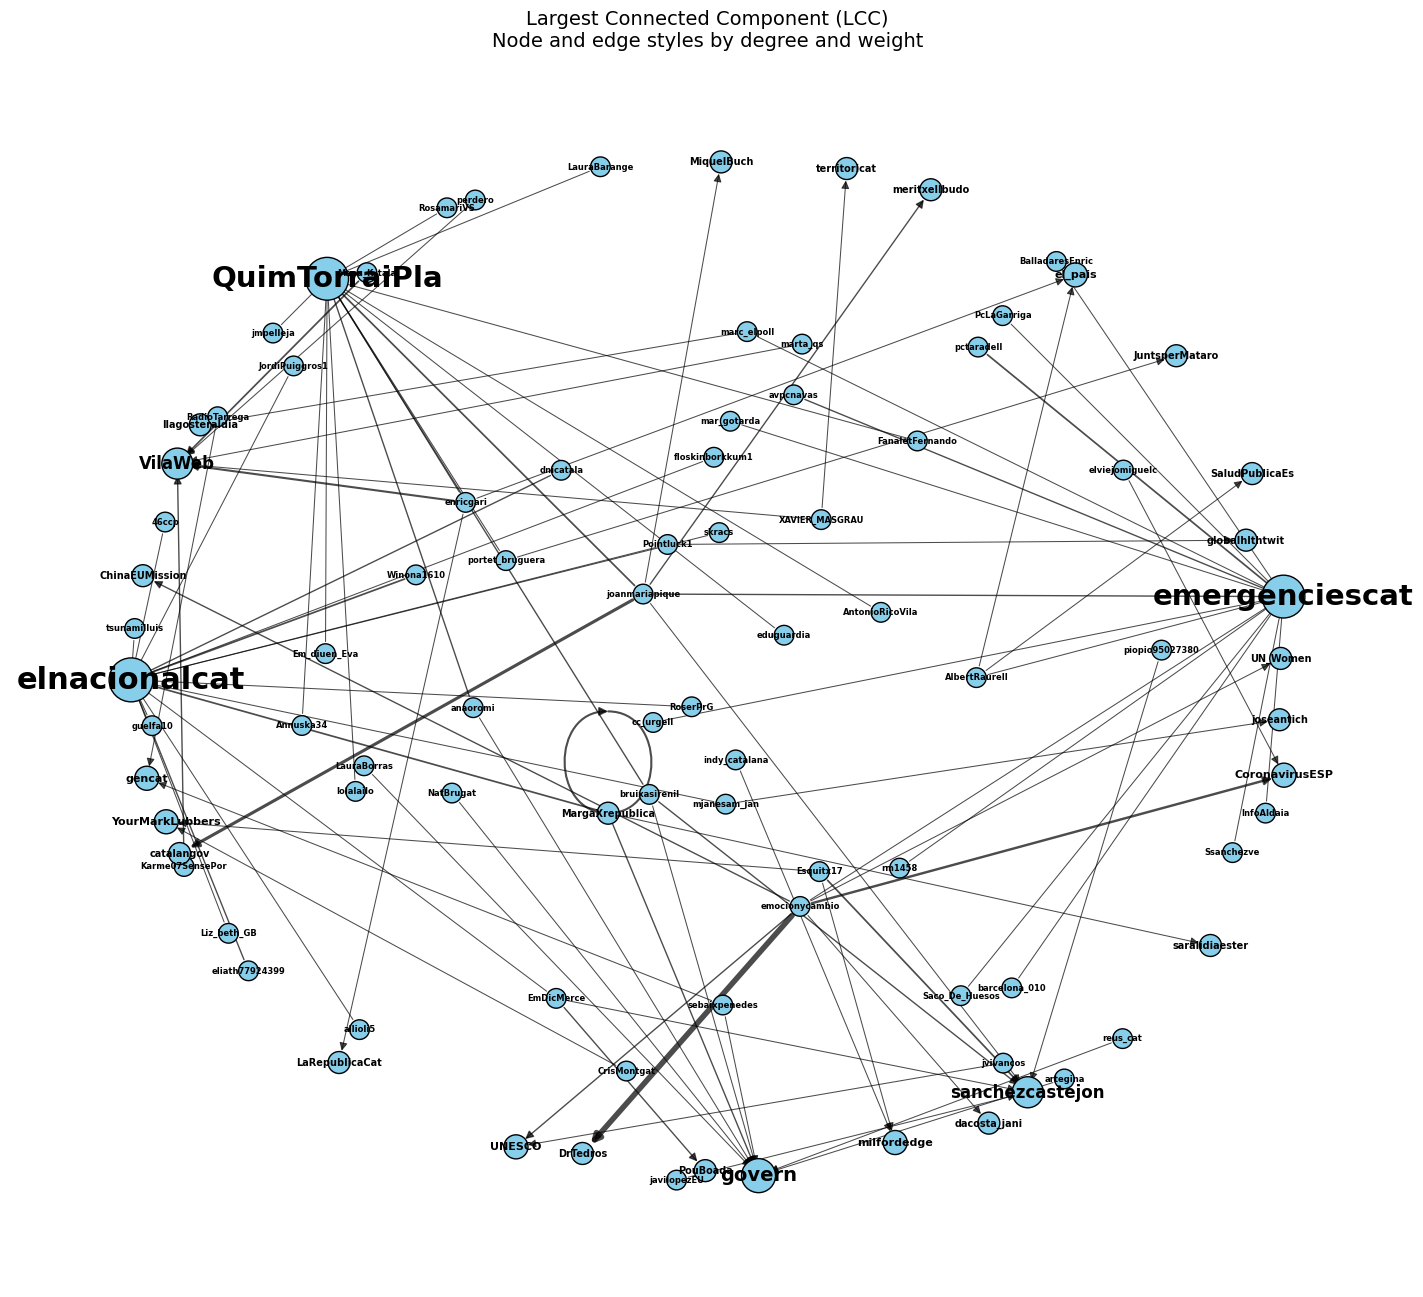


Observation:
If you remove the `seed` parameter from `spring_layout()`, the network layout changes each time you run it.
This happens because the algorithm initializes node positions randomly.
The `seed` parameter fixes that randomness, making the layout reproducible across runs.


In [105]:
import matplotlib.pyplot as plt
import networkx as nx


lcc_undirected = lcc.to_undirected()

diameter = nx.diameter(lcc_undirected)

# Tamaño del componente más grande
largest_cc_size = lcc.number_of_nodes()
total_nodes = g.number_of_nodes()
largest_cc_percent = (largest_cc_size / total_nodes) * 100

components = sorted(nx.weakly_connected_components(g), key=len, reverse=True)
second_largest_cc_size = len(components[1]) if len(components) > 1 else 0

print(f"Diameter of the largest connected component: {diameter}")
print(f"Largest connected component size: {largest_cc_size} nodes ({largest_cc_percent:.2f}% of total)")
print(f"Second largest connected component size: {second_largest_cc_size} nodes")

pos = nx.spring_layout(lcc, seed=12, k=5, iterations=300)

# Resultado:
# El parámetro 'seed' controla la aleatoriedad del algoritmo de layout.
# Cuando se elimina, cada ejecución produce una disposición distinta de los nodos,
# ya que el algoritmo parte de posiciones iniciales aleatorias.
# Con un 'seed' fijo, la disposición se mantiene constante entre ejecuciones.


# Nodo: tamaño y etiquetas proporcionales al in-degree
node_in_degree = dict(lcc.in_degree())
node_sizes = [200 + 50 * node_in_degree[n] for n in lcc.nodes()]
label_sizes = {n: 6 + node_in_degree[n] for n in lcc.nodes()}


edge_weights = [d["weight"] * 0.25 for _, _, d in lcc.edges(data=True)]

plt.figure(figsize=(18, 16))
nx.draw_networkx_edges(lcc, pos, width=edge_weights, alpha=0.7, arrows=True, arrowsize=12)
nx.draw_networkx_nodes(lcc, pos, node_size=node_sizes, node_color="skyblue", edgecolors="black")

for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=label_sizes[node], ha="center", va="center", fontweight="bold")

plt.title("Largest Connected Component (LCC)\nNode and edge styles by degree and weight", fontsize=14)
plt.axis("off")

plt.savefig("mentions-largest-cc.png")
plt.show()

print("\nObservation:")
print("If you remove the `seed` parameter from `spring_layout()`, the network layout changes each time you run it.")
print("This happens because the algorithm initializes node positions randomly.")
print("The `seed` parameter fixes that randomness, making the layout reproducible across runs.")



## 2.3. Examine degree distributions


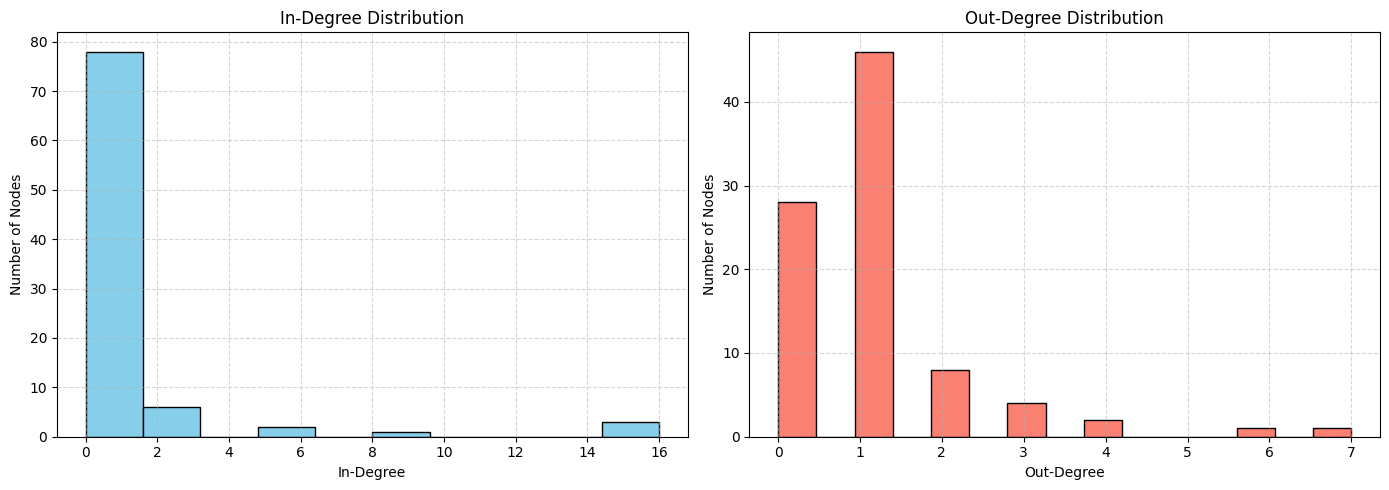

In [106]:
# Compute in-degree and out-degree
in_degrees = dict(lcc.in_degree())
out_degrees = dict(lcc.out_degree())

# Extract values
in_values = list(in_degrees.values())
out_values = list(out_degrees.values())

# --- Plot 1: Degree distributions ---
plt.figure(figsize=(14, 5))

# In-degree distribution
plt.subplot(1, 2, 1)
plt.hist(in_values, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("In-Degree")
plt.ylabel("Number of Nodes")
plt.title("In-Degree Distribution")
plt.grid(True, linestyle='--', alpha=0.5)

# Out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_values, bins=15, color='salmon', edgecolor='black')
plt.xlabel("Out-Degree")
plt.ylabel("Number of Nodes")
plt.title("Out-Degree Distribution")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



In-Degree Distribution (izquierda):
La mayoría de los nodos tienen un in-degree de 0 o 1, lo que significa que reciben muy pocas menciones o ninguna. Solo unos pocos nodos tienen valores altos (por ejemplo, 14 o 16), lo que indica la existencia de actores muy influyentes, en este caso personas o instituciones importantes.

Out-Degree Distribution (derecha):
También aquí predomina el out-degree bajo, especialmente 0 y 1. Esto sugiere que la mayoría de las cuentas mencionan a pocos otros usuarios. Sin embargo, algunos alcanzan valores de 6 o 7, lo que indica la presencia de usuarios más activos.

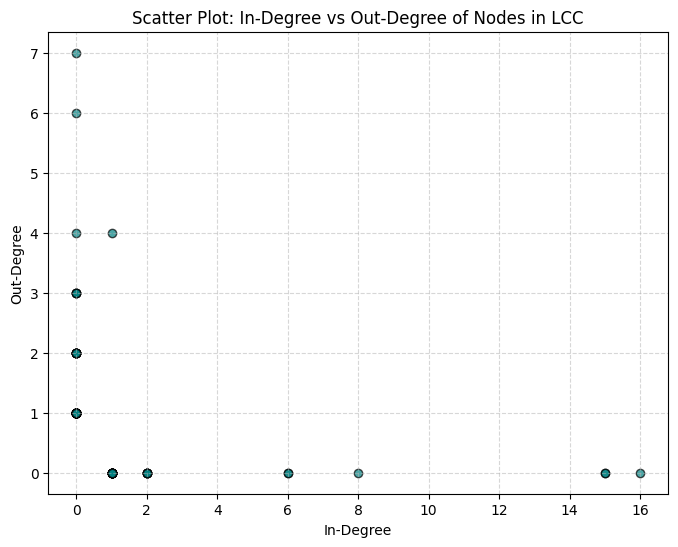

In [107]:
# --- Plot 2: Scatter plot of in-degree vs out-degree ---
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(in_values, out_values, color='teal', alpha=0.7, edgecolors='black')
plt.xlabel("In-Degree")
plt.ylabel("Out-Degree")
plt.title("Scatter Plot: In-Degree vs Out-Degree of Nodes in LCC")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


La mayoría de los nodos tienen valores bajos de in-degree y out-degree, lo que indica que la mayoría de ellos no están fuertemente interconectados.
Hay unos pocos nodos con in-degree alto pero out-degree bajo (por ejemplo, los que están cerca de 15–16 en el eje X y 0 en el eje Y). Esto sugiere que reciben muchas menciones, pero no mencionan tanto a otros, actuando como nodos más influyentes o centrales.

La distribución dispersa y la ausencia de puntos cercanos a la diagonal indican que no hay mucha bidireccionalidad en las conexiones: los flujos de mención son más unidireccionales que recíprocos

# 3. Create the undirected co-mention network


In [108]:
co_mentions_counter = {}

with gzip.open(COMPRESSED_INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    for line in input_file:
        tweet = json.loads(line)
        author = tweet['user']['screen_name']
        message = tweet['full_text']

        mentions = extract_mentions(message)

        for mention1 in mentions:
            for mention2 in mentions:
                if mention1 < mention2:  
                    co_mentions_counter.setdefault((mention1, mention2), 0)
                    co_mentions_counter[(mention1, mention2)] += 1

for pair, count in list(co_mentions_counter.items())[:10]:
    print(f"Accounts @{pair[0]} and @{pair[1]} were co-mentioned {count} times")


Accounts @aramateix and @govern were co-mentioned 5 times
Accounts @IldeVrMy and @pr_soc were co-mentioned 2 times
Accounts @VilaWeb and @vpartal were co-mentioned 2 times
Accounts @Nigel_Farage and @SteveLawrence_ were co-mentioned 1 times
Accounts @YahooActualidad and @microBIOblog were co-mentioned 1 times
Accounts @ElJuristaCat and @comunicacioicab were co-mentioned 1 times
Accounts @ElJuristaCat and @ProcuradorsICPB were co-mentioned 1 times
Accounts @ElJuristaCat and @procuradorsc were co-mentioned 1 times
Accounts @comunicacioicab and @procuradorsc were co-mentioned 1 times
Accounts @ProcuradorsICPB and @comunicacioicab were co-mentioned 4 times


In [109]:
# Leave this code as-is

print(co_mentions_counter[('educaciocat', 'elnacionalcat')])

8


In [110]:
for key in co_mentions_counter:
    if co_mentions_counter[key] >= 20:
        print(f"Accounts @{key[0]} and @{key[1]} were co-mentioned {co_mentions_counter[key]} times")

Accounts @VilaWeb and @mossos were co-mentioned 20 times
Accounts @QuimTorraiPla and @govern were co-mentioned 92 times
Accounts @sanchezcastejon and @tjparfitt were co-mentioned 28 times
Accounts @elnacionalcat and @joseantich were co-mentioned 90 times
Accounts @QuimTorraiPla and @tjparfitt were co-mentioned 59 times
Accounts @QuimTorraiPla and @sanchezcastejon were co-mentioned 25 times
Accounts @emergenciescat and @govern were co-mentioned 31 times
Accounts @josepcosta and @sanchezcastejon were co-mentioned 49 times
Accounts @eldiarioes and @iescolar were co-mentioned 28 times
Accounts @gencat and @govern were co-mentioned 105 times
Accounts @mossos and @semgencat were co-mentioned 44 times
Accounts @elnacionalcat and @juansrod1 were co-mentioned 30 times
Accounts @QuimTorraiPla and @emergenciescat were co-mentioned 75 times
Accounts @Antoni_Gelonch and @sanchezcastejon were co-mentioned 106 times


In [111]:
lines_written = 0

with io.open(OUTPUT_CO_MENTIONS_FILENAME, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"')
    writer.writerow(["Source", "Target", "Weight"])
    for key in co_mentions_counter:
        author = key[0]
        mention = key[1]
        weight = co_mentions_counter[key]
        writer.writerow([author, mention, weight])
        lines_written += 1

print(f"Wrote {lines_written} lines to file {OUTPUT_CO_MENTIONS_FILENAME}")

Wrote 7816 lines to file CovidLockdownCatalonia-co-mentions.csv


# 4. Visualize the undirected co-mention network 

In [112]:
# Crear un grafo dirigido
subG = nx.DiGraph()

with open(OUTPUT_CO_MENTIONS_FILENAME, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")  
    for row in reader:
        source = row["Source"]
        target = row["Target"]
        weight = int(row["Weight"])
        if weight >= 17:
            subG.add_edge(source, target, weight=weight)

print(f"Número de nodos: {subG.number_of_nodes()}")
print(f"Número de aristas: {subG.number_of_edges()}")

Número de nodos: 24
Número de aristas: 20


In [113]:
nx.get_edge_attributes(subG, 'weight')

{('VilaWeb', 'mossos'): 20,
 ('mossos', 'semgencat'): 44,
 ('QuimTorraiPla', 'govern'): 92,
 ('QuimTorraiPla', 'tjparfitt'): 59,
 ('QuimTorraiPla', 'sanchezcastejon'): 25,
 ('QuimTorraiPla', 'emergenciescat'): 75,
 ('govern', 'yeyaboya'): 19,
 ('sanchezcastejon', 'tjparfitt'): 28,
 ('sanchezcastejon', 'vilallongapac'): 19,
 ('elnacionalcat', 'joseantich'): 90,
 ('elnacionalcat', 'mlasalas'): 18,
 ('elnacionalcat', 'juansrod1'): 30,
 ('emergenciescat', 'govern'): 31,
 ('josepcosta', 'sanchezcastejon'): 49,
 ('eldiarioes', 'iescolar'): 28,
 ('gencat', 'govern'): 105,
 ('ISGLOBALorg', 'joethebrew'): 18,
 ('desdelamoncloa', 'sanchezcastejon'): 19,
 ('RaloksFuriano', 'pablom_m'): 18,
 ('Antoni_Gelonch', 'sanchezcastejon'): 106}

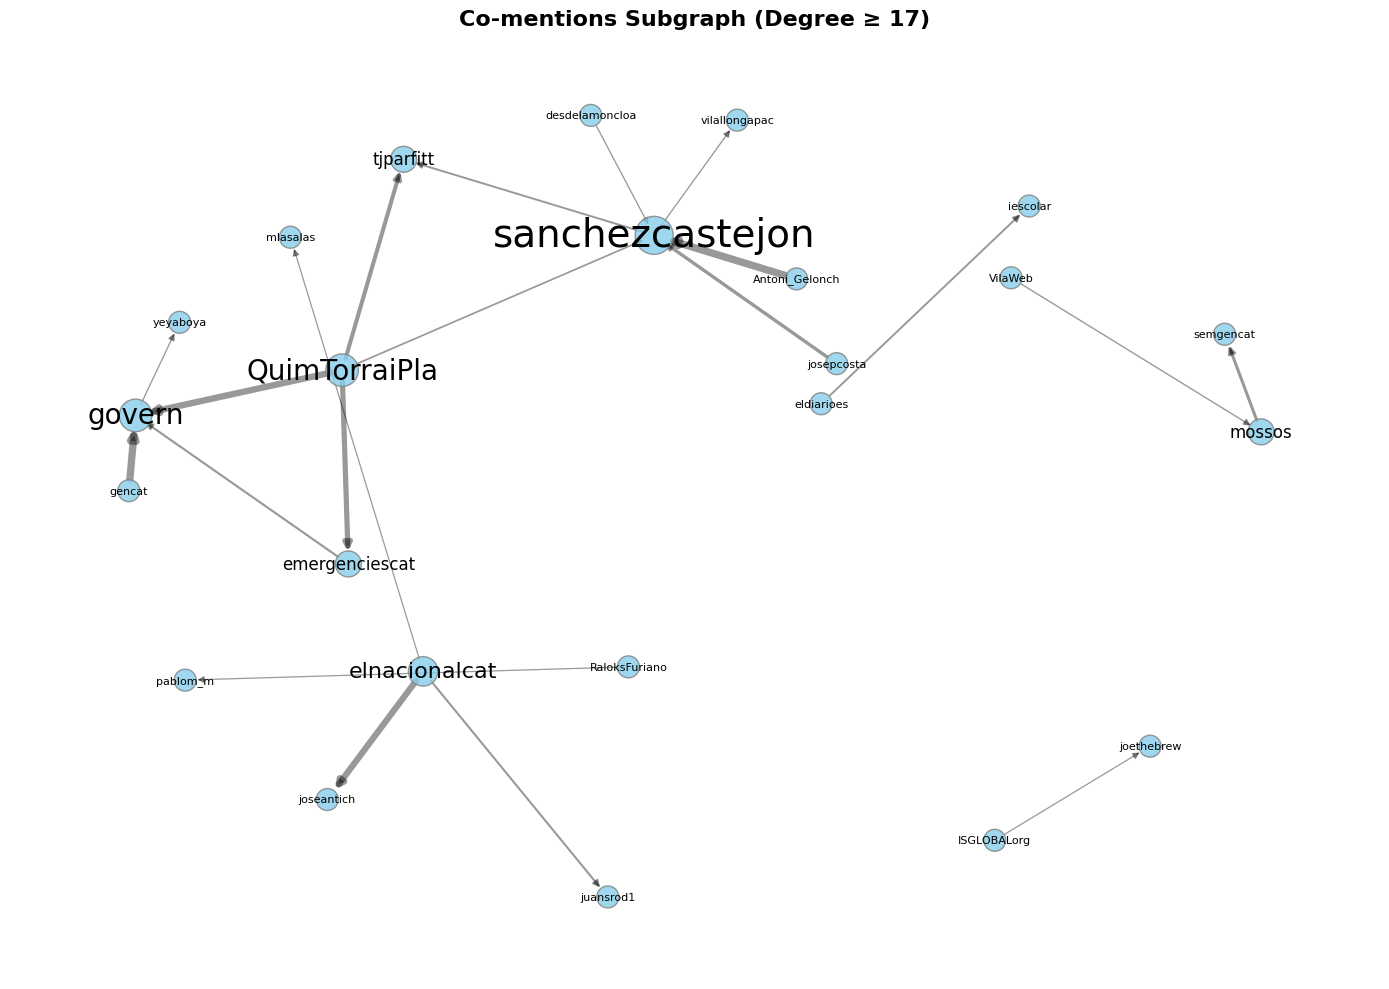

In [114]:
pos = nx.spring_layout(subG, weight='weight', k=10, iterations=300, seed=42, gravity=1)


plt.figure(figsize=(14, 10))
plt.title("Co-mentions Subgraph (Degree ≥ 17)", fontsize=16, fontweight='bold')

# Node sizes can reflect degree
node_sizes = [150 + subG.degree(n) * 100 for n in subG.nodes()]
edge_weights = [d['weight'] for _, _, d in subG.edges(data=True)]
label_sizes = {n: 4 + subG.degree(n)*4 for n in subG.nodes()}


# Draw edges
nx.draw_networkx_edges(subG, pos, alpha=0.4, width=[w * 0.05 for w in edge_weights])

# Draw nodes
nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8, edgecolors='gray')

# Draw labels
nx.draw_networkx_labels(subG, pos, font_size=label_sizes, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.show()

Revisando el grafo, podemos observar un componente conectado principal que relaciona tres grandes nodos: Govern, Quim Torra y Pla, y Sánchez-Castejón. Este componente se asocia claramente con el ámbito político, ya que incluye al Govern y a Quim Torra, entonces presidente de Cataluña, y a Sánchez-Castejón, presidente de España. Este sería el grupo más conectado del grafo.

Además, se identifican otros componentes menores, como el de El Nacional Cat, que agrupa seis nodos. También aparece un conjunto formado por el diario.es y Escolar. Otro grupo está compuesto por VilaWeb, Mossos y semgencat, que conforman un trío conectado. Finalmente, se encuentra un último componente con IsGlobalOrg y joethebrew, que están vinculados entre sí.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, text, and figures were produced by myself.</font>